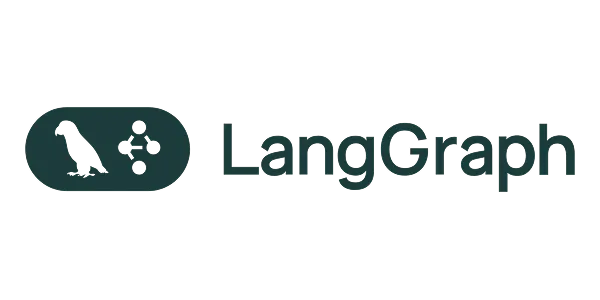

## Streaming

## What is Streaming?
- Models usually generate text **token by token** (piece by piece).
- Instead of waiting for the whole answer, we can **receive tokens as they are generated**.
- This gives:
  - Faster **first response** (user sees something early).
  - More **interactive experience** (like typing effect).

---


### Key bullets
- **What is streaming?** Incremental token/chunk emission from an autoregressive model instead of waiting for the full completion.
- **Why streaming?** Lower perceived latency, progressive UI updates, early execution of output (e.g., start synthesis or search while text still streaming).
- **How models produce tokens:** Autoregressive decoding loop — model predicts next token conditioned on previous tokens.

    - The model works step by step, predicting the next token at each step:

        Look at all tokens so far (context).

        Predict the probability distribution of the next token.

        Sample (or pick the highest probability) → that becomes the next token.

        Repeat until end-of-sequence (like <EOS>) or max length.

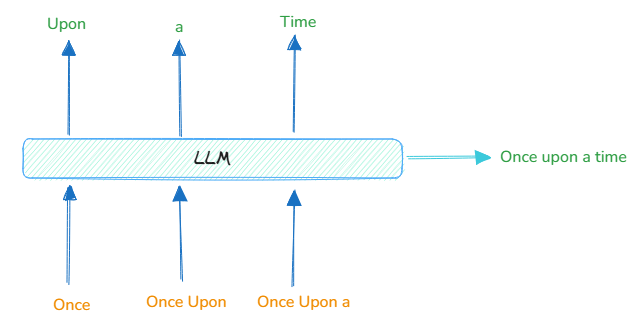

- **How Decoding Strategies Work in LLMs**

    When a model generates text, it does it **one token (word or subword) at a time**.  
    At each step, the model predicts a **probability distribution** over possible next tokens.  
    Different **decoding strategies** decide how to pick the next token.



    **Example Prompt:** 
    **“Once upon a …”**  

    Possible next tokens with probabilities:  
      `time` (80%)  
      `day` (10%)  
      `kingdom` (5%)  
      `story` (5%)  
    

    
    1. **Greedy Decoding**
      Always pick the token with the **highest probability**.  
      Output: **“time”**  
    
    
    
    2. **Beam Search**
      Explore multiple candidate sequences in parallel.  
      Keeps the top few (beams) and picks the best overall.  
      Output: usually **“time”**, but continuation may be better structured.  
    
    
    
    3. **Top-k Sampling** (k = 2)
      Only consider the **top k tokens**.  
      Randomly pick from them.  
      Choices: `[time, day]`  
      Output: **“time”** or **“day”**  
    
    
    
    4. **Top-p (Nucleus) Sampling** (p = 0.9)
      Pick from the **smallest set of tokens whose total probability ≥ p**.  
      For p = 0.9 → `[time, day]` (covers 90%).  
      Output: **“time”** or **“day”**  
    
    
    
    5. **Temperature**
      Controls randomness in sampling.  
      Low temperature (0.1) → focuses on the most likely token → **“time”** almost always  
      High temperature (1.0) → more randomness → could be **“day”**, **“kingdom”**, or **“story”**  
    
    
    This is why when you stream tokens (`updates` vs `values` mode), 

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [ ]:
# # OPTIONAL
# import os
# os.environ["GOOGLE_API_KEY"] = "your-gemini-key"

# from langchain.prompts import ChatPromptTemplate
# from langchain_google_genai import ChatGoogleGenerativeAI

# # Setup Gemini 1.5 Flash model
# model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

In [3]:
import os
from langchain_openai import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Setup Azure OpenAI model
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-open-ai-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "youe-azure-endpoint"


model = AzureChatOpenAI(
    azure_deployment="gpt-4o",   # replace with your deployment name in Azure
    api_version="2024-02-01",    # optional, update if your resource uses a different version
    temperature=0
)

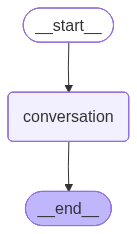

In [4]:
from IPython.display import Image, display
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

# LLM
# model = ChatOpenAI(model="gpt-4o", temperature=0) 

# 2. Define state
class State(MessagesState):
    pass

# 3. Conversation node (agent logic)
def conversation_node(state: State):
    response = model.invoke(state["messages"])
    return {"messages": [response]}

# 4. Build simple workflow: START → conversation → END
workflow = StateGraph(State)
workflow.add_node("conversation", conversation_node)
workflow.add_edge(START, "conversation")
workflow.add_edge("conversation", END)

# 5. Compile with memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming in LangGraph
Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 

LangGraph allows you to **stream the state of the graph** as it executes node by node.  
This is very useful to:
- See **partial results** without waiting for the whole graph to finish.
- Build **real-time dashboards** or chat UIs.
- Debug what’s happening **inside each node**.

---

## Two Streaming Modes
- **`values`** → streams the **full state** of the graph after each node runs.
- **`updates`** → streams **only the changes (deltas)** after each node runs.


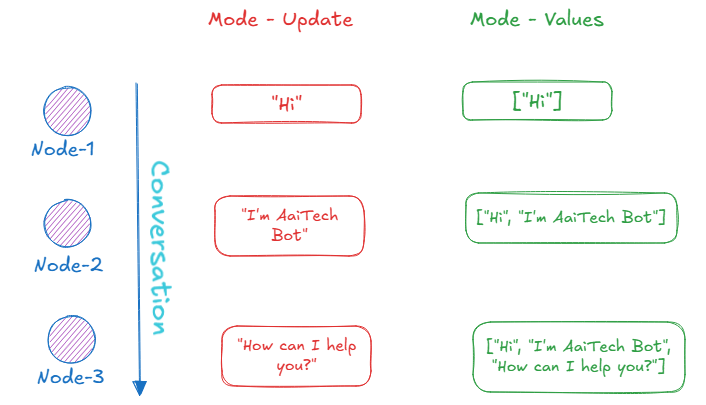

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Tell me the capital of France in one line")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': [AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 35, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CK7q5jy3T76YpOmyW01Vj2oSY8zG3', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': Fa

In [10]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Tell me the capital of France in one line")]}, config, stream_mode="updates"):
    for msg in chunk["conversation"]["messages"]:
        msg.pretty_print()

================================== Ai Message ==================================

The capital of France is Paris.


In [12]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Tell me the capital of Paris in one line")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Tell me the capital of India in one line
================================== Ai Message ==================================

The capital of India is **New Delhi**.
================================ Human Message =================================

Tell me the capital of Paris in one line
---------------------------------------------------------------------------
================================ Human Message =================================

Tell me the capital of India in one line
================================== Ai Message ==================================

The capital of India is **New Delhi**.
================================ Human Message =================================

Tell me the capital of Paris in one line
================================== Ai Message ==================================

Paris is a city and the capital of **France**; it does not have a separate capital.
------------------------

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [13]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me the capital of France in one line")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: AzureChatOpenAI
Node: conversation. Type: on_chat_model_end. Name: AzureChatOpenAI
Node: conversation. Type: on_chain_stream. Name: conversa

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [14]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me the capital of France in one line")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    print(event["data"])

{'input': {'messages': [HumanMessage(content='Tell me the capital of France in one line', additional_kwargs={}, response_metadata={})]}}
{'input': {'messages': [HumanMessage(content='Tell me the capital of France in one line', additional_kwargs={}, response_metadata={}, id='2ba7151e-c184-4a04-b6ea-d859643d3582')]}}
{'input': {'messages': [[HumanMessage(content='Tell me the capital of France in one line', additional_kwargs={}, response_metadata={}, id='2ba7151e-c184-4a04-b6ea-d859643d3582')]]}}
{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--7c17e87d-f787-40b7-bd2e-0ab75f85dfc7')}
{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--7c17e87d-f787-40b7-bd2e-0ab75f85dfc7')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--7c17e87d-f787-40b7-bd2e-0ab75f85dfc7')}
{'chunk': AIMessageChunk(content=' capital', additional_kwargs={}, response_metadata={}, id='run--7c17e87d-f

In [15]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me the capital of France in one line")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content=' capital', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content=' France', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run--d7774aa7-9d8b-4f43-9f26-96b71babe965')}
{'chunk': AIMessageChunk(content=' Paris', additional_kwargs={}, r

In [19]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about France and its economy")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end=" ")

  France ,  officially  the  French  Republic ,  is  a  major  country  in  Western  Europe  known  for  its  rich  history ,  culture ,  and  global  influence .  It  is  the  largest  country  in  the  European  Union  by  land  area  and  is  bordered  by  countries  such  as  Germany ,  Italy ,  Spain ,  and  Belgium ,  as  well  as  the  Atlantic  Ocean  and  the  Mediterranean  Sea .  Its  capital ,  Paris ,  is  a  global  center  for  art ,  fashion ,  and  culture ,  and  the  country  is  famous  for  landmarks  like  the  Eiffel  Tower ,  the  Louvre  Museum ,  and  the  Palace  of  Versailles .

 ###  ** France 's  Economy **
 France  has  one  of  the  largest  and  most  advanced  economies  in  the  world ,  ranking  as  the   7 th  largest  by  nominal  GDP  ( as  of   202 3 ).  It  is  a  mixed  economy  that  combines  private  enterprise  with  significant  government  involvement ,  particularly  in  public  services  and  infrastructure .  Below  are  key  aspects 